<a href="https://colab.research.google.com/github/carlosvneves/gegef-concebra-trafprev/blob/main/traffic_proj_concebra_MetaProphet(soma).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Teste) Previsão do volume de tráfego por praça de pedágio CONCEBRA -  P1

## Preliminares

### Instalação das bibliotecas necessárias

In [1]:
# para o caso de executar o código no googlecolab
#!pip install pycaret-ts-alpha
#!pip install requests==2.23.0
!pip install xlrd
!pip install -q -U watermark
!pip install -q plotly
!pip install -q -U statsmodels
!pip install -q fbprophet
!pip install -q convertdate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
     |████████████████████████████████| 9.8 MB 4.6 MB/s 


### Importação das bibliotecas

In [2]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
import fbprophet
from fbprophet import Prophet

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "GEGEF/SUROD/ANTT - Dezembro de 2021" --iversions

Author: GEGEF/SUROD/ANTT - Dezembro de 2021

numpy      : 1.19.5
matplotlib : 3.2.2
sys        : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
IPython    : 5.5.0
plotly     : 4.4.1
statsmodels: 0.13.1
sklearn    : 0.0
fbprophet  : 0.7.1
scipy      : 1.4.1
pandas     : 1.1.5
seaborn    : 0.11.2



### Funções auxiliares

In [4]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

### Diretório da base de dados

In [5]:
# muda o diretório de trabalho
%cd /content/drive/MyDrive/Colab Notebooks/GEGEF_concebra

/content/drive/MyDrive/Colab Notebooks/GEGEF_concebra


### Lê os dados relativos à P1 e seleciona a série para a qual será realizada a previsão (tratamento final dos dados)

In [226]:
#@title Escolha a Praça de Pedágio para Análise:


p = "P11" #@param ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9","P10", "P11"] 

print(p)

P11


In [227]:
data = pd.read_excel('TráfegoCONCEBRA-Adj.xlsx', sheet_name=p)

In [228]:
data.tail()

,date,Tipo de Veículo,Veículo de Passeio 2 eixos,Veículo Comercial 2 eixos,Veículo de Passeio 3 eixos,Veículo Comercial 3 eixos,Veículo de Passeio 4 eixos,Veículo Comercial 4 eixos,Veículo Comercial 5 eixos,Veículo Comercial 6 eixos,Motos,Veículo Comercial 7 eixos,Veículo Comercial 8 eixos,Veículo Comercial 9 eixos,Veículo Comercial 10 eixos,Veículo Comercial Acima de 10 eixos,Soma das categorias,Qtde de eixos suspensos
43,2020-10,31.0,46257.0,5272.0,633.0,4547.0,33.0,3131.0,1998.0,4451.0,818.0,2828.0,85.0,3897.0,0,10,73991.0,13342.0
44,2020-11,30.0,46589.0,5171.0,569.0,4090.0,36.0,3024.0,1944.0,4055.0,955.0,2723.0,134.0,4722.0,0,8,74050.0,12299.0
45,2020-12,31.0,51867.0,5290.0,615.0,3920.0,39.0,2845.0,1869.0,3724.0,826.0,2452.0,85.0,3402.0,0,11,76976.0,11184.0
46,2021-01,31.0,45397.0,4809.0,526.0,3978.0,36.0,2758.0,1828.0,4315.0,865.0,2638.0,72.0,4453.0,0,5,71711.0,12004.0
47,2021-02,28.0,40267.0,4798.0,446.0,3973.0,24.0,2996.0,1930.0,4024.0,718.0,2264.0,58.0,3522.0,0,5,65053.0,10880.0


In [229]:
#data.set_index('date', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   48 non-null     object 
 1   Tipo de Veículo                        45 non-null     float64
 2   Veículo de Passeio 2 eixos             48 non-null     float64
 3   Veículo Comercial 2 eixos              48 non-null     float64
 4   Veículo de Passeio 3 eixos             48 non-null     float64
 5   Veículo Comercial 3 eixos              48 non-null     float64
 6   Veículo de Passeio 4 eixos             48 non-null     float64
 7   Veículo Comercial 4 eixos              48 non-null     float64
 8   Veículo Comercial 5 eixos              48 non-null     float64
 9   Veículo Comercial 6 eixos              48 non-null     float64
 10  Motos                                  48 non-null     float64
 11  Veículo 

In [230]:
data.describe()

,Tipo de Veículo,Veículo de Passeio 2 eixos,Veículo Comercial 2 eixos,Veículo de Passeio 3 eixos,Veículo Comercial 3 eixos,Veículo de Passeio 4 eixos,Veículo Comercial 4 eixos,Veículo Comercial 5 eixos,Veículo Comercial 6 eixos,Motos,Veículo Comercial 7 eixos,Veículo Comercial 8 eixos,Veículo Comercial 9 eixos,Veículo Comercial 10 eixos,Veículo Comercial Acima de 10 eixos,Soma das categorias,Qtde de eixos suspensos
count,45.00000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.000000,48.000000
mean,30.40000,42164.688172,4387.065188,455.105511,3566.034274,39.074597,2570.150538,1536.493952,2605.338710,997.185484,1883.818548,40.746640,1921.518817,0.0,1.541667,62197.262097,8763.342058
std,0.83666,3940.502448,438.150118,81.775680,488.506585,12.000891,516.479511,376.220944,794.071799,114.885231,585.722974,34.690348,1051.967935,0.0,2.517668,6633.692792,2269.932450
min,28.00000,31201.000000,3408.000000,312.000000,2640.000000,14.000000,1530.000000,787.000000,1441.000000,718.000000,806.000000,12.000000,674.903226,0.0,0.000000,49010.000000,5168.000000
25%,30.00000,38506.500000,4066.250000,396.500000,3193.500000,31.500000,2202.250000,1308.750000,2032.250000,920.250000,1441.000000,17.000000,1194.250000,0.0,0.000000,56803.750000,7033.500000
50%,31.00000,42667.500000,4346.500000,443.000000,3522.000000,38.500000,2491.000000,1481.500000,2378.000000,1006.000000,1747.500000,27.000000,1537.000000,0.0,1.000000,62279.000000,8571.000000
75%,31.00000,44387.250000,4781.500000,489.250000,3947.500000,48.250000,2974.000000,1870.250000,2995.750000,1086.500000,2324.000000,43.500000,2522.500000,0.0,2.000000,65986.750000,10530.250000
max,31.00000,51867.000000,5290.000000,692.000000,4580.000000,66.000000,3665.000000,2257.000000,4451.000000,1312.000000,3166.000000,153.000000,4722.000000,0.0,11.000000,76976.000000,13655.000000


### Prepara os dados para a previsão via Meta - Prophet

In [231]:
# Agregando os dados da praça por categoria 
ts_SumP1 = pd.DataFrame(data[['date','Soma das categorias']]) # selecting the needed columns
ts_SumP1['date'] = ts_SumP1['date'].astype('datetime64')
ts_SumP1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 48 non-null     datetime64[ns]
 1   Soma das categorias  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [232]:
# Separa os dados em treino e teste
train_size = int(len(ts_SumP1) * 0.8)
trainset, testset = ts_SumP1[0:train_size], ts_SumP1[train_size:] 

In [233]:
# Criando dataframes para dados de treino e teste
df_treino = pd.DataFrame({'ds':trainset['date'], 'y':trainset['Soma das categorias']})
df_teste = pd.DataFrame({'ds':testset['date'], 'y':testset['Soma das categorias']})

In [234]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 38 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      10 non-null     datetime64[ns]
 1   y       10 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 292.0 bytes


### Previsão via Meta Prophet Lib (antiga FB-Prophet)

In [235]:
#m = Prophet()
#m.fit(ts_SumP1)
m = Prophet(n_changepoints=1, seasonality_mode = 'multiplicative',interval_width = 0.95, yearly_seasonality = True).fit(df_treino)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [236]:
future = m.make_future_dataframe(periods=len(testset) , freq='MS')


In [237]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43,2020-10-01,69127.337926,64350.584562,73965.752470
44,2020-11-01,69621.271786,65088.180516,74431.760923
45,2020-12-01,79221.339006,74947.558453,84271.813724
46,2021-01-01,75270.512613,70563.435651,79966.214221
47,2021-02-01,68545.210392,64030.673199,73287.486052


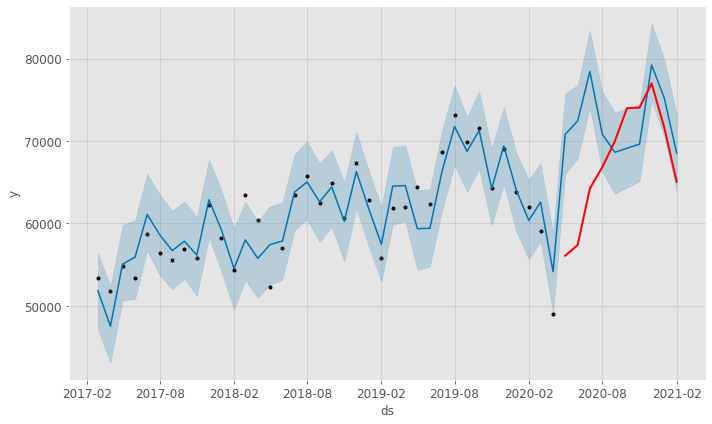

In [238]:
# Vamos criar um Plot e conferir as previsões

# Plot das previsões
fig = m.plot(forecast)

# Dados de Teste em vermelho
plt.plot(df_teste['ds'],df_teste['y'], label = 'Teste', color = 'red', linewidth = 2)
plt.show()

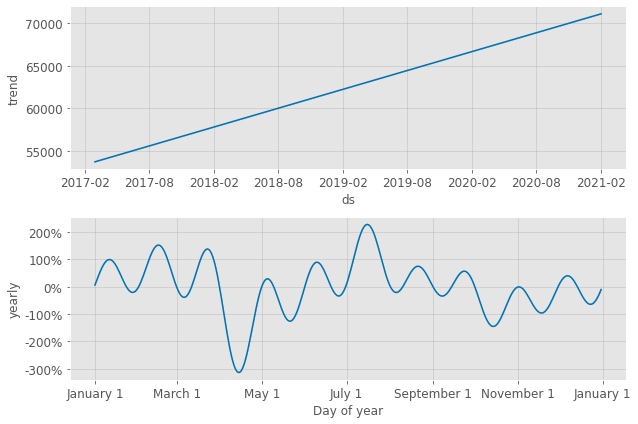

In [239]:
fig2 = m.plot_components(forecast)

In [240]:
# Calculando a performance 
prophet_results = performance(df_teste['y'], forecast[38:48]['yhat'])
prophet_results

MSE das previsões é 73529027.97
RMSE das previsões é 8574.91
MAPE das previsões é 10.82


In [241]:
dataset_para_previsoes = m.make_future_dataframe(periods = 48, freq = 'MS')
dataset_para_previsoes.count()

ds    86
dtype: int64

In [242]:
# Forecast
forecast_modelo_prophet = m.predict(dataset_para_previsoes)

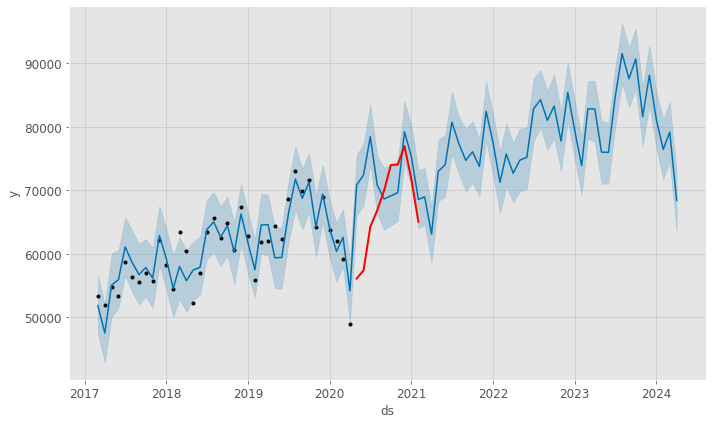

In [243]:
# Vamos criar um Plot e conferir as previsões

# Plot das previsões
fig = m.plot(forecast_modelo_prophet)

# Dados de Teste em vermelho
plt.plot(df_teste['ds'],df_teste['y'], label = 'Teste', color = 'red', linewidth = 2)
plt.show()

In [244]:
filename = "prophet_out_" + p + ".xlsx"
output = pd.DataFrame(forecast_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
input = (ts_SumP1)
input.rename(columns={"date":"ds"}, inplace=True)
output = pd.merge(output, input, on=["ds"], how="outer")
output.to_excel(filename,
             sheet_name=p) 

print("Resultados da previsão gravados no arquivo:" + filename)

Resultados da previsão gravados no arquivo:prophet_out_P11.xlsx
